# Prédiction de série temporelle avec Gpytorch

## Introduction

Diverses méthodes de prévision de la ressource solaire sont étudiées au laboratoire PROMES CNRS.
L’une d’entre elles est la régression par processus gaussiens (GPR, pour Gaussian process
regression). Des expérimentation réalisées à l’aide du logiciel Matlab ont permis d’obtenir des
résultats encourageants pour la prévision de l’éclairement global horizontal (GHI, pour global
horizontal irradiance).

L’objectif de ce projet est de mettre en oeuvre la régression par processus gaussiens, non pas avec le logiciel Matlab, mais à l’aide d’une bibliothèque Python nommée GPyTorch. 

Il faudra donc en quelque sorte, retranscrire le code Matlab en code Python, et parvenir à un code propre et minimal permettant d’obtenir des résultats similaires à ceux obtenus avec Matlab.

**Ce projet est constitué de 5 grandes étapes :**

- 1ère étape:  Importation des données (entrainement et test) directement de matlab.
- 2ème étape:  Création d'un modèle.
- 3ème étape:  Initialisation des hyperparamètres du modèle.
- 4ème étape:  Optimisation des hyperparamètres du modèle suivi d'une pahse d'entrainement.
- 5ème étape:  Phase de test.

## 1ère étape:  Importation des données

In [1]:
import math
import torch
import matplotlib.pyplot as plt
import pandas as pd
import gpytorch
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# ########################################################

#Création et importations des données d'entrainement
X_train = pd.read_csv('xtraining_matlab.csv')
X_train = torch.DoubleTensor(X_train.xtraining.to_numpy())

Y_train = pd.read_csv('ytraining_matlab.csv')
Y_train = torch.DoubleTensor(Y_train.ytraining.to_numpy())

# ########################################################

#Création et importations des données de la phase de test
X_test = pd.read_csv('xtest_matlab.csv')
X_test = torch.DoubleTensor(X_test.xtest.to_numpy())

Y_test = pd.read_csv('ytest_matlab.csv')
Y_test = torch.DoubleTensor(Y_test.ytest.to_numpy())

# ########################################################

data01 = pd.read_csv('GHI_20190423_20190713_10min.csv')
data01.rename(
    columns={'Time':'Date'},inplace=True)
data01['Date'] = pd.to_datetime(data01['Date'])

date_train = data01['Date'][0:2118]
date_test = data01['Date'][2118:2414]

# ########################################################

Y_MU = pd.read_csv('YMU_matlab.csv')

# ########################################################
print(X_train.shape)
# print(Y_train.shape)

print(X_test.shape)
# print(Y_test.shape)

print(date_train.shape)
print(date_test.shape)

torch.Size([2118])
torch.Size([296])
(2118,)
(296,)


### Visualisation des données

**Le code ci-dessous permet de visualiser les données dont nous disposons. Nous pouvons donc voir, que les mesures du GHI ont été recueillis toutes les 10 minutes. Ici sont affichées uniquement les données d'entraînement.**

In [38]:
X_train_vis = pd.read_csv('xtraining_matlab.csv')
X_test_vis = pd.read_csv('xtest_matlab.csv')
data02 = data01.copy()


# ########################################################
GHI_training_vis = data02.iloc[0:2118,:]
GHI_test_vis = data02.iloc[2118:2414,:]

print(GHI_training_vis)

                    Date        GHI
0    2019-04-23 04:50:00   3.477802
1    2019-04-23 05:00:00   5.275347
2    2019-04-23 05:10:00   8.673586
3    2019-04-23 05:20:00  17.896339
4    2019-04-23 05:30:00  25.514603
...                  ...        ...
2113 2019-05-15 18:30:00  30.057301
2114 2019-05-15 18:40:00  14.166875
2115 2019-05-15 18:50:00   8.998108
2116 2019-05-15 19:00:00   4.817962
2117 2019-05-15 19:10:00   3.000128

[2118 rows x 2 columns]


**Afin de pouvoir instiller les données de temps dans notre modèle une transformation à préalablement été faite avec la méthode "timestamp". Les valeurs du temps sont donc différentes.**

In [34]:
# ########################################################
GHI_training_vis['Date'] = X_train_vis['xtraining'].values
GHI_test_vis['Date'] = X_test_vis['xtest'].values

# ########################################################
data_frames = [GHI_training_vis, GHI_test_vis]
result_data_frames = pd.concat(data_frames)


print(result_data_frames)

               Date        GHI
0     737538.201389   3.477802
1     737538.208333   5.275347
2     737538.215278   8.673586
3     737538.222222  17.896339
4     737538.229167  25.514603
...             ...        ...
2409  737563.770833  41.716952
2410  737563.777778  23.667651
2411  737563.784722  14.147029
2412  737563.791667   6.497310
2413  737563.798611   3.101396

[2414 rows x 2 columns]


c:\users\dem\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\dem\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


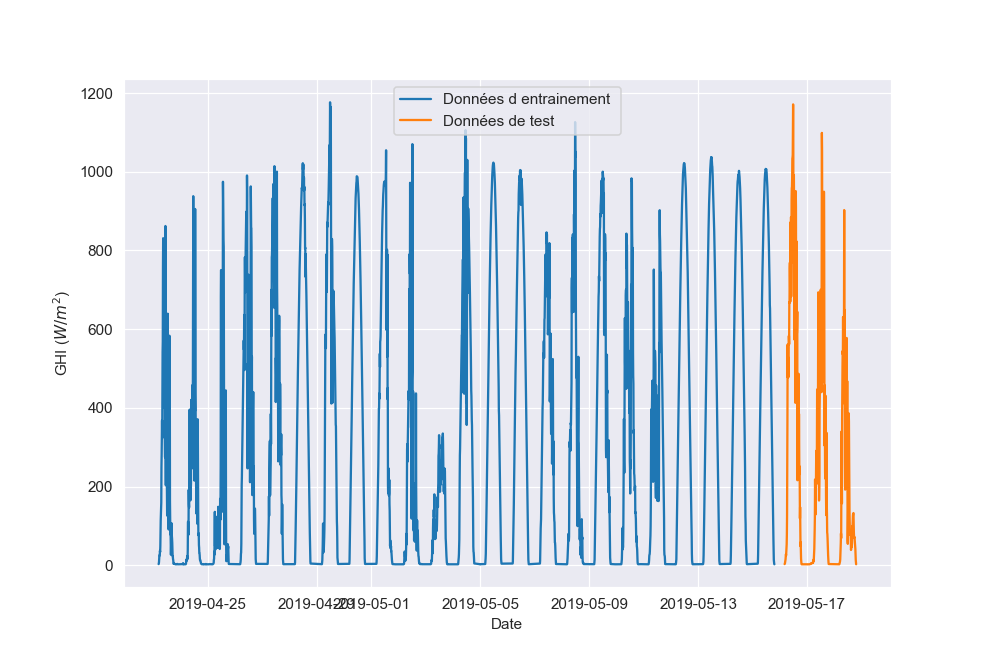

In [30]:
%matplotlib notebook
plt.figure(figsize=(9,6))
plt.plot(date_train,Y_train)
plt.plot(date_test,Y_test)
plt.xlabel('Date')
plt.ylabel('GHI ($W/m^2$)')
plt.legend(['Données d entrainement ', 'Données de test'])
plt.show()

## 2ème étape: Création d'un modèle de Régression par GP

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        
        PeriodicKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        RQKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
        
        self.covar_module = gpytorch.kernels.ProductKernel(PeriodicKernel,RQKernel)
        
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [21]:
# Initialisation de la fonction de vraissemblance et du modele
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, Y_train, likelihood)

## 3ème étape : Initialisation des hyperparamètres

In [22]:
# hyp_matlab =[0.2298,-0.0013,-0.6986,-2.7964,-1.5327,-3.1434]
# hyp_python = []
# for n in hyp_matlab:
#     exp_matlab = np.exp(n)
#     hyp_python.append(exp_matlab)
#     print(exp_matlab)
    
# print("\n",hyp_python)

In [7]:
model.likelihood.initialize(noise=0.1)

##################################################################
# Initialisation du noyau Periodic
model.covar_module.kernels[0].base_kernel.initialize(lengthscale=1.2583)
model.covar_module.kernels[0].base_kernel.initialize(period_length=0.9987)
model.covar_module.kernels[0].initialize(outputscale=0.4972)

##################################################################
# Initialisation du noyau RQ
model.covar_module.kernels[1].base_kernel.initialize(lengthscale=0.0610)
model.covar_module.kernels[1].initialize(outputscale=0.2159)
model.covar_module.kernels[1].base_kernel.initialize(alpha=0.0431)

##################################################################
# Affichage des valeurs initilaisés
print('Noise :',model.likelihood.noise_covar.noise,"\n")
print('Peridoc Kernel lengthscale [L(P)]:',model.covar_module.kernels[0].base_kernel.lengthscale)
print('périod_length [p_length] :',model.covar_module.kernels[0].base_kernel.period_length,"\n")
print('Periodic outputscale [p_sig]:',model.covar_module.kernels[0].outputscale)

print('RQ lengthscale L(RQ):',model.covar_module.kernels[1].base_kernel.lengthscale)
print('RQ outputscale :',model.covar_module.kernels[1].outputscale)
print('Alpha : ',model.covar_module.kernels[1].base_kernel.alpha)

Noise : tensor([0.1000], grad_fn=<AddBackward0>) 

Peridoc Kernel lengthscale [L(P)]: tensor([[1.2583]], grad_fn=<SoftplusBackward>)
périod_length [p_length] : tensor([[0.9987]], grad_fn=<SoftplusBackward>) 

Periodic outputscale [p_sig]: tensor(0.4972, grad_fn=<SoftplusBackward>)
RQ lengthscale L(RQ): tensor([[0.0610]], grad_fn=<SoftplusBackward>)
RQ outputscale : tensor(0.2159, grad_fn=<SoftplusBackward>)
Alpha :  tensor([0.0431], grad_fn=<SoftplusBackward>)


## 4ème étape : Entrainement du modèle et optimisation des hyperparamètres

In [8]:
# Entrainement du modèle afin de trouver les paramètres approximant au mieux nos données
model = model.double()
model.train()
likelihood.train()

# Algorithme d'optimisation, ici "Adam" sera utilisé pour optimiser les valeurs des hyperparamètres de chaque kernel
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.375)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [9]:
training_iter = 100

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    
    
    # the way the PyTorch optimizer works is that it looks for a variable called loss,
    # which also has a gradient (calc by calling backward), and tries to reduce it.
    loss = -mll(output, Y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   L(P): %.3f  p_length: %.3f p_sig: %.3f  L(RQ): %.3f  RQ_sig: %.3f Alpha: %.3f  ' % (
        i + 1, training_iter, loss,
        model.covar_module.kernels[0].base_kernel.lengthscale,
        model.covar_module.kernels[0].base_kernel.period_length,
        model.covar_module.kernels[0].outputscale,
        model.covar_module.kernels[1].base_kernel.lengthscale,
        model.covar_module.kernels[1].outputscale,
        model.covar_module.kernels[1].base_kernel.alpha,
#         model.likelihood.noise
    ))
    optimizer.step()

c:\users\dem\appdata\local\programs\python\python37\lib\site-packages\gpytorch\utils\linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ..\aten\src\ATen\native\Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 1/100 - Loss: 58254.413   L(P): 1.258  p_length: 0.999 p_sig: 0.497  L(RQ): 0.061  RQ_sig: 0.216 Alpha: 0.043  
Iter 2/100 - Loss: 63221.156   L(P): 1.005  p_length: 1.251 p_sig: 0.661  L(RQ): 0.042  RQ_sig: 0.301 Alpha: 0.062  
Iter 3/100 - Loss: 33529.193   L(P): 0.784  p_length: 1.404 p_sig: 0.857  L(RQ): 0.029  RQ_sig: 0.410 Alpha: 0.088  
Iter 4/100 - Loss: 18305.013   L(P): 0.605  p_length: 1.527 p_sig: 1.078  L(RQ): 0.021  RQ_sig: 0.546 Alpha: 0.123  
Iter 5/100 - Loss: 11964.542   L(P): 0.465  p_length: 1.579 p_sig: 1.308  L(RQ): 0.015  RQ_sig: 0.699 Alpha: 0.164  
Iter 6/100 - Loss: 8603.495   L(P): 0.365  p_length: 1.621 p_sig: 1.537  L(RQ): 0.012  RQ_sig: 0.865 Alpha: 0.210  
Iter 7/100 - Loss: 6928.479   L(P): 0.297  p_length: 1.657 p_sig: 1.761  L(RQ): 0.010  RQ_sig: 1.039 Alpha: 0.257  
Iter 8/100 - Loss: 6031.696   L(P): 0.251  p_length: 1.690 p_sig: 1.977  L(RQ): 0.008  RQ_sig: 1.215 Alpha: 0.303  
Iter 9/100 - Loss: 5408.084   L(P): 0.221  p_length: 1.719 p_sig: 2

## 5ème étape : Validation du modèle et visualisation des résultats

In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [13]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    observed_pred_train = likelihood(model(X_train))

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


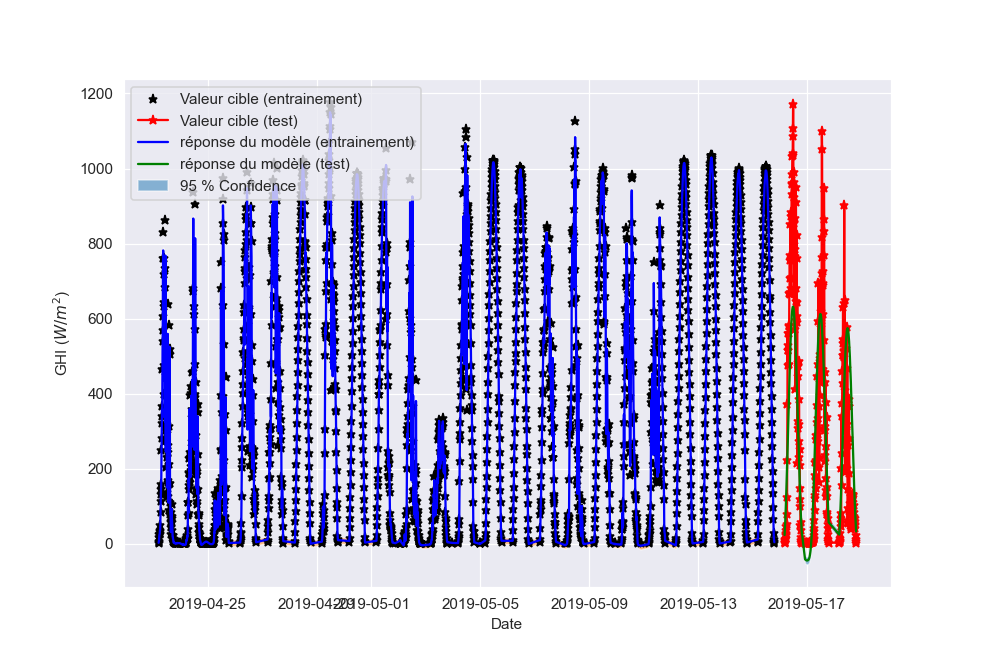

In [24]:
 with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(9,6))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower2, upper2 = observed_pred_train.confidence_region()
    
    # Plot training data as black stars
    ax.plot(date_train,Y_train, 'k*')
    
    # Plot test data as red stars
    ax.plot(date_test,Y_test, '-r*')
    
    # Plot the result of the GPR training as blue line
    ax.plot(date_train,observed_pred_train.mean.numpy(), 'b')
    
    # Plot predictive means as red line
    ax.plot(date_test, observed_pred.mean.numpy(), 'g')
    
    plt.xlabel('Date')
    plt.ylabel('GHI ($W/m^2$)')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(date_test, lower.numpy(), upper.numpy(), alpha=0.5)
    ax.fill_between(date_train, lower2.numpy(), upper2.numpy(), alpha=0.5)
    ax.legend(['Valeur cible (entrainement) ', 'Valeur cible (test)','réponse du modèle (entrainement)' ,'réponse du modèle (test)','95 % Confidence'])

**Dans l'objectif d'améliorer les résultats obtenus, une autre méthode a été implémenté.
Cette fois-ci je vais prédire les données de test par intervalle de 10 minutes, en utilisant l'ensemble des données précedentes . Ce principe est en quelque sorte une fenetre glissante  modifié, dont la taille grandit à chaque pas de temps.** 

In [18]:
X_data = X_train
Y_data = Y_train

hp = 1
n = 0

mini_test = torch.tensor(())
Y_pred = torch.DoubleTensor()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    
    #réponse du modèle aux données d'entrainement (ici la date)
    pred_train = likelihood(model(X_train))
    
    #Boucle permettant la prédiction sur un horizon de prédiction
    for i in range (0,len(X_test)+1,hp):
        
        
        # 1. -- tenseur regroupant la/les observation a fournir au modele. il est évidemment different a chaque pas de temps
        mini_test = X_test[i:i+hp]
        
        # phase de test : réponse du modèle a/aux observation donnée(s)
        pred_01 = likelihood(model(mini_test)).loc
        
        # tenseur final regroupant toutes les réponses/prédictions du modèle ayant été faite à chaque pas de temps
        Y_pred = torch.cat((Y_pred,pred_01),0)
        
        
        # 2. -- tenseur regroupant les nouvelles observations permettant de mettre a jour le modèle.
        # A chaque itération on fourni donc au modèle toutes les précedente observations
        a1 = X_test[i:i+hp]
        a2 = Y_test[i:i+hp]
        X_data = torch.cat((X_data,a1),0)
        Y_data = torch.cat((Y_data,a2),0)
        
        # permet de fournir/mettre a jour le modèle avec de nouvelle donnée a chaque pas de temps
        # l'argument "strict" si il est faux autorise l'insertion dans le modèle des données n'ayant pas les mêmes
        # dimensions que celles fournis originellement au modèle.
        model.set_train_data(X_data,Y_data,strict=False)
        

c:\users\dem\appdata\local\programs\python\python37\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


<IPython.core.display.Javascript object>


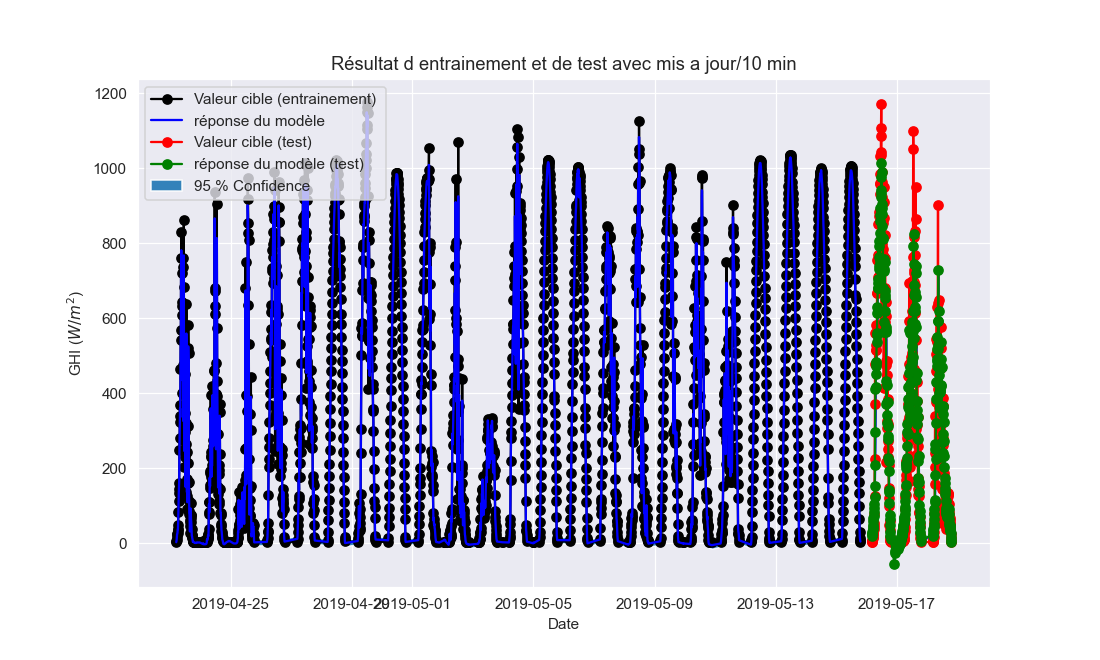

In [40]:
%matplotlib notebook
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10,6))
    
###############################################

    # Plot training data as black stars
    ax.plot(date_train, Y_train, '-ko')
    # Get upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    ax.fill_between(date_train, lower.numpy(), upper.numpy(), alpha=0.9)
    # Plot train means 
    ax.plot(date_train, pred_train.mean.numpy(), '-b')
    
    
###############################################

    # Plot test data as red stars
    ax.plot(date_test,Y_test, '-ro')
    # Plot predictive means 
    ax.plot(date_test, Y_pred.numpy(), '-go')
    # Confidence interval
    ci = 1.96 * torch.std(Y_pred)/torch.mean(Y_pred)
    ax.fill_between(date_test, (Y_pred-ci), (Y_pred+ci), color='b', alpha=0.8)
    
    plt.xlabel('Date')
    plt.ylabel('GHI ($W/m^2$)')
    plt.title('Résultat d entrainement et de test avec mis a jour/10 min')
    ax.legend(['Valeur cible (entrainement) ', 'réponse du modèle','Valeur cible (test)' ,'réponse du modèle (test)','95 % Confidence'])

**Sur le graphique ci-dessous est présenté le résultat obtenu initialment sur matlab comparé avec le réusltat obtenu ici sur python.**

<IPython.core.display.Javascript object>


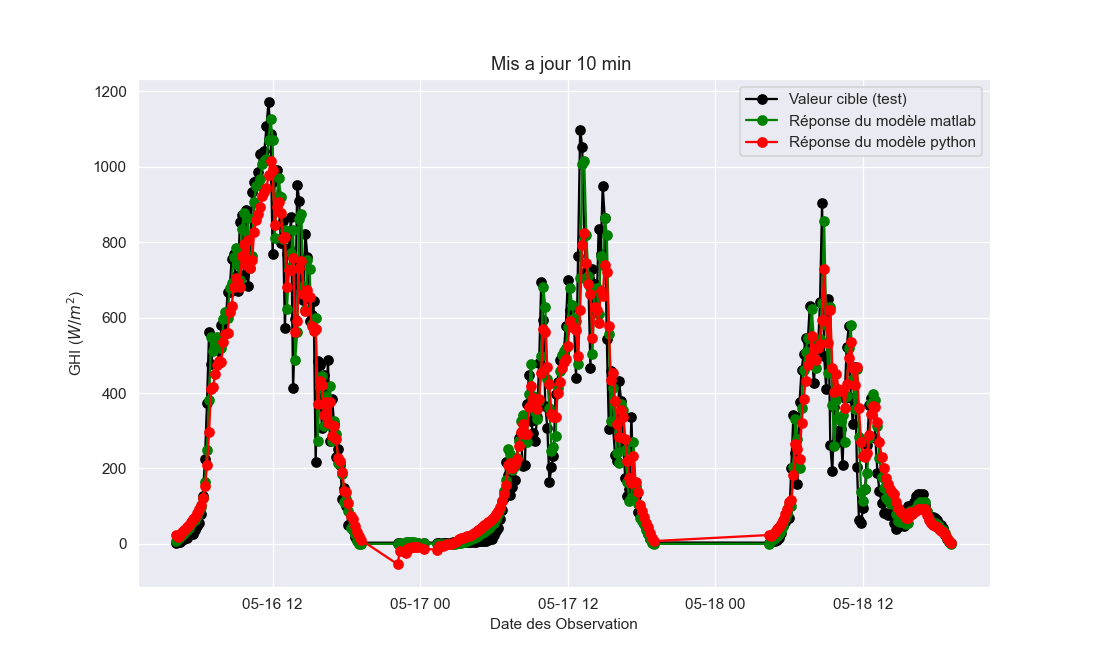

In [24]:
###############################################
# Tracé de matlab 
%matplotlib notebook
plt.figure(figsize=(10,6))
plt.plot(date_test, Y_test, '-ko')
plt.plot(date_test,Y_MU,'-go')
plt.plot(date_test,Y_pred,'-ro')
plt.title("Mis a jour 10 min ")
plt.xlabel('Date des Observation')
plt.ylabel('GHI ($W/m^2$)')
plt.legend(['Valeur cible (test)', 'Réponse du modèle matlab', 'Réponse du modèle python'])
plt.show()

### Condition initiale :
-	Vecteur des hyperparamètre :

hyperparamètres issue de matlab :  [0.2298   -0.0013   -0.6986   -2.7964   -1.5327   -3.1434]

Fonction exp appliqué au vecteur (hyp) : [1.2583, 0.9987, 0.4972, 0.0610, 0.2159, 0.0431]

### Nombre d'itération = 100

## <u> Résultats finaux </u>


### <u> Fonction de covariance périodique <u> :

#### Matlab :
- Lenghtscale (L) = 0.8285
- Periodic lengthscale = 0.9996
- Outputscale ($\sigma$) = 23.8861

#### Python :
- Lenghtscale (L) = 0.241
- Periodic lengthscale = 2.002
- Outputscale ($\sigma$) = 5.336


### <u>Fonction de covariance RQ <u>:

#### Matlab :
- Lenghtscale (L) = 0.0340
- Outputscale ($\sigma$) = 10.3729
- RQ lengthscale = 0.0687 


#### Python :
- Lenghtscale (L) = 0.004
- Outputscale ($\sigma$) = 4.503
- RQ lengthscale = 0.132



    
### <u>Fonction de vraisemblance marginale (loss) </u>:
    
#### Matlab : 12355

#### Python : 392.361


    
### <u> Mean squared error (MSE) </u>:    
    
#### Matlab : 11 168

#### Python : 12 028    
    
    
### <u> Root Mean squared error (RMSE) </u>:    
    
#### Matlab : 105.6773

#### Python : 109.6     
    
    

In [16]:
MSE = mean_squared_error(Y_test,Y_pred)
RMSE = (np.sqrt(MSE))
print("MSE :",MSE)
print("RMSE :",RMSE)

MSE : 12018.677197799023
RMSE : 109.62972771013811
